In [359]:
import glob
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import PIL.Image as Image
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import pickle
import cv2
from PIL import Image
from keras import models
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import imageio

In [323]:
im = Image.open('archive/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg')
width, height = im.size
print(im.size)

(256, 256)


In [324]:
path='archive/real_vs_fake/real-vs-fake/'

In the following code snippet we analyze the structure of our dataset. Our dataset contains 140,000 labeled images ("fake", "real"). Each image is placed in one of the folders named "train", "test", "valid".

In [325]:
dataset = {"image_path":[],"label":[],"folder":[]}
for folder in os.listdir(path):
    for label in os.listdir(path+"/"+folder):
        for image in glob.glob(path+folder+"/"+label+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["label"].append(label)
            dataset["folder"].append(folder)
df = pd.DataFrame(dataset)
df

,image_path,label,folder
0,archive/real_vs_fake/real-vs-fake/valid/real/0...,real,valid
1,archive/real_vs_fake/real-vs-fake/valid/real/1...,real,valid
2,archive/real_vs_fake/real-vs-fake/valid/real/1...,real,valid
3,archive/real_vs_fake/real-vs-fake/valid/real/0...,real,valid
4,archive/real_vs_fake/real-vs-fake/valid/real/5...,real,valid
...,...,...,...
139995,archive/real_vs_fake/real-vs-fake/train/fake/4...,fake,train
139996,archive/real_vs_fake/real-vs-fake/train/fake/4...,fake,train
139997,archive/real_vs_fake/real-vs-fake/train/fake/4...,fake,train
139998,archive/real_vs_fake/real-vs-fake/train/fake/C...,fake,train


In the following two code cells we can see how the instances are perfectly balanced: 70,000 instances belong to the "fake" class and 70,000 to the "real" class.

In [326]:
df[df['label']=='fake'].count()

image_path    70000
label         70000
folder        70000
dtype: int64

In [327]:
df[df['label']=='real'].count()

image_path    70000
label         70000
folder        70000
dtype: int64

In the next row, we can observe how the instances of fake faces look very real

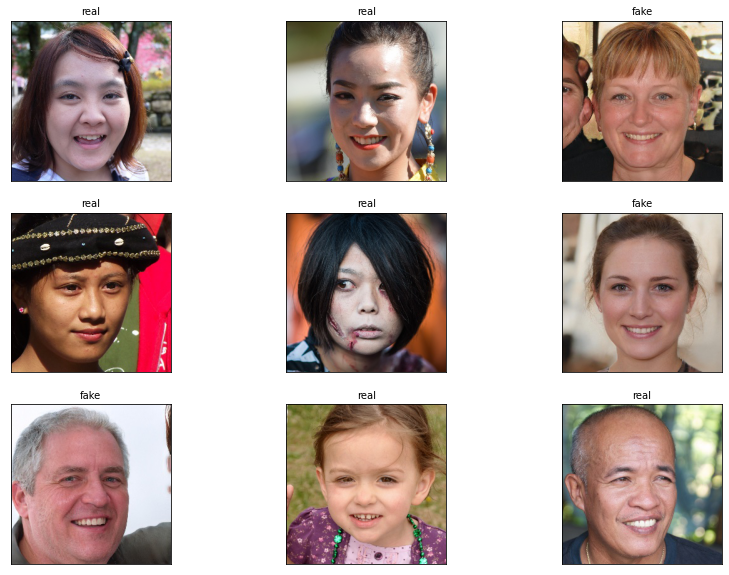

In [328]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(df))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(df.loc[random,"image_path"]))
    plt.title(df.loc[random, "label"], size = 10) 
    plt.xticks([])
    plt.yticks([])
plt.show()

In the following code snippet we have split our dataset into three parts: a part called "train_gen" used to train the main binary classification model; a second part called "test_gen" used to test the model and see its ability to generalize on unseen instances; the last part named with "valid_gen" is used to train the Deep Convolutional Generative Adversarial network.

In [329]:
train_gen = image_dataset_from_directory(directory="archive/real_vs_fake/real-vs-fake/train", 
                                    image_size=(128, 128), shuffle=True)

test_gen = image_dataset_from_directory(directory="archive/real_vs_fake/real-vs-fake/test",
                                        image_size=(128, 128), shuffle=True)

valid_gen = image_dataset_from_directory(directory="archive/real_vs_fake/real-vs-fake/valid/real",
                                         label_mode=None, image_size=(128, 128), batch_size=32, shuffle=True)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 10000 files belonging to 1 classes.


In the following code cell we have scaled the pixels of each dataset image.

In [330]:
rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))
valid_gen = valid_gen.map(lambda image:(rescale(image)))

In [331]:
input_shape = (128, 128, 3)
batch_size = 128
num_classes = 2
epochs = 15

In the next step we built our binary classification model to recognize if an image represents a fake or real face.

In [332]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, kernel_size = (5,5), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(num_classes, activation = 'softmax'))

Here our model is compiled and we can see its structure.

In [333]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_48 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_128 (Conv2D)         (None, 59, 59, 128)       204928    
                                                                 
 batch_normalization_49 (Bat  (None, 59, 59, 128)      512       
 chNormalization)                                                
                                                     

In [ ]:
checkpoint = ModelCheckpoint(filepath='/Users/Me/Desktop/models_dir/bigmodel.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('/Users/Me/Desktop/models_dir/training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In the following code snippet, the classifier is trained 

In [335]:
%%time
history = model.fit(train_gen, validation_data=test_gen, callbacks=callbacks, epochs = epochs, batch_size=batch_size)

Epoch 1/15
3125/3125 [==============================] - ETA: 0s - loss: 0.5201 - accuracy: 0.7454
Epoch 1: val_loss improved from inf to 0.38032, saving model to /Users/alessioferrone/Desktop/models_dir/bigmodel.h5
3125/3125 [==============================] - 3543s 1s/step - loss: 0.5201 - accuracy: 0.7454 - val_loss: 0.3803 - val_accuracy: 0.8288 - lr: 0.0100
Epoch 2/15
3125/3125 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8384
Epoch 2: val_loss improved from 0.38032 to 0.27291, saving model to /Users/alessioferrone/Desktop/models_dir/bigmodel.h5
3125/3125 [==============================] - 3692s 1s/step - loss: 0.3613 - accuracy: 0.8384 - val_loss: 0.2729 - val_accuracy: 0.8891 - lr: 0.0100
Epoch 3/15
3125/3125 [==============================] - ETA: 0s - loss: 0.2847 - accuracy: 0.8795
Epoch 3: val_loss improved from 0.27291 to 0.26855, saving model to /Users/alessioferrone/Desktop/models_dir/bigmodel.h5
3125/3125 [==============================] - 3693s 

In [336]:
hist = history.history

In [337]:
# Pickle the history to file
with open('history.pkl', 'wb') as f:
    pickle.dump(hist, f)

Next, we save the binary classification model.

In [338]:
model.save("bigmodel.h5")

Now, we can load the saved model and we can use it as we want.

In [342]:
model_loaded = load_model("bigmodel.h5")

In [343]:
y_pred = model_loaded.predict(test_gen)

625/625 [==============================] - 210s 334ms/step


In the following line we calculated the accuracy on the testing set obtaining a score of 0.9777.

In [344]:
test_loss, test_acc = model_loaded.evaluate(test_gen)

625/625 [==============================] - 212s 338ms/step - loss: 0.0640 - accuracy: 0.9777


In [345]:
print(y_pred[0])
print(y_pred[0][1])

[9.9985766e-01 1.4228185e-04]
0.00014228185


In [346]:
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

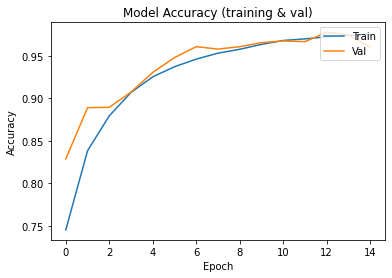

In [347]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('Model Accuracy (training & val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

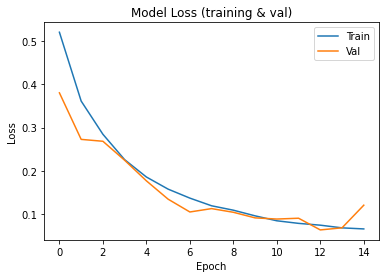

In [348]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [349]:
ypred = y_pred.argmax(axis=-1)

In [350]:
ypred

array([0, 1, 0, ..., 1, 1, 1])

At this point, the Deep Convolutional Generative Adversarial Network was built. It consists of a discriminator and a generator.

In [352]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
discriminator.add(BatchNormalization())
discriminator.add(MaxPooling2D(pool_size = (2, 2)))

discriminator.add(Conv2D(128, kernel_size = (5,5), activation = 'relu'))
discriminator.add(BatchNormalization())
discriminator.add(MaxPooling2D(pool_size = (2, 2)))
discriminator.add(Dropout(0.20))

discriminator.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
discriminator.add(BatchNormalization())
discriminator.add(MaxPooling2D(pool_size = (2, 2)))
discriminator.add(Dropout(0.30))

discriminator.add(Flatten())
discriminator.add(Dense(128, activation = 'relu'))
discriminator.add(BatchNormalization())
discriminator.add(Dropout(0.20))
discriminator.add(Dense(1, activation = 'softmax'))
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_52 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_131 (Conv2D)         (None, 59, 59, 128)       204928    
                                                                 
 batch_normalization_53 (Bat  (None, 59, 59, 128)      512       
 chNormalization)                                                
                                                     

In [353]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 8192)              1056768   
                                                                 
 reshape_76 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_255 (Conv2  (None, 16, 16, 64)       131136    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_241 (LeakyReLU)  (None, 16, 16, 64)       0         
                                                                 
 conv2d_transpose_256 (Conv2  (None, 32, 32, 128)      131200    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_242 (LeakyReLU)  (None, 32, 32, 128)      0 

In [354]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [368]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("gan_images/generated_img_%03d_%d.png" % (epoch, i))

We train DCGAN for 30 epochs.

In [369]:
epochs = 30 

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    valid_gen, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/30
313/313 [==============================] - 1393s 4s/step - d_loss: 0.2230 - g_loss: 5.0651
Epoch 2/30
313/313 [==============================] - 1394s 4s/step - d_loss: 0.1190 - g_loss: 4.1259
Epoch 3/30
313/313 [==============================] - 1390s 4s/step - d_loss: 0.1473 - g_loss: 3.9729
Epoch 4/30
313/313 [==============================] - 1501s 5s/step - d_loss: 0.2794 - g_loss: 3.2780
Epoch 5/30
313/313 [==============================] - 1405s 4s/step - d_loss: 0.2749 - g_loss: 2.8856
Epoch 6/30
313/313 [==============================] - 1482s 5s/step - d_loss: 0.2933 - g_loss: 3.0536
Epoch 7/30
313/313 [==============================] - 1448s 5s/step - d_loss: 0.2702 - g_loss: 2.7372
Epoch 8/30
313/313 [==============================] - 1387s 4s/step - d_loss: 0.2215 - g_loss: 2.7669
Epoch 9/30
313/313 [==============================] - 1388s 4s/step - d_loss: 0.2254 - g_loss: 3.9163
Epoch 10/30
313/313 [==============================] - 1419s 5s/step - d_loss: 0.2

In [370]:
gan.save_weights("gan.h5")

Here we show one of the best instances generated by DCGAN after 30 epochs.

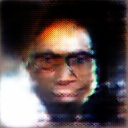

In [400]:
im_gen = imageio.imread('gan_images/generated_img_025_2.png')
img = Image.fromarray(im_gen)
img

In this code cell, we tested our binary classification model on the previous image and as we might expect it is rightly predicted as a fake instance. This was predictable given that, having only performed 30 epochs of training, an image not fully defined but with clear human features will be clearly classified as fake. In fact, in order to have reliable estimates, the DCGAN should be trained for more than 100 epochs but for reasons of time (for training) and resources we could not do it.

In [402]:
img_gen_array = np.array(im_gen)
img_gen_array = img_gen_array.astype("float") / 255.0
img_gen_array = np.expand_dims(img_gen_array, axis=0)
prediction_gen = model.predict(img_gen_array)
if prediction_gen[0][0] > prediction_gen[0][1]:
    pred_gen = "The image is "+"Fake: {0:.4f}%".format(prediction_gen[0][0]*100)
    print(pred_gen)
else:
    pred_gen = "The image is "+"Real: {0:.4f}%".format(prediction_gen[0][1]*100)
    print(pred_gen)

1/1 [==============================] - 0s 45ms/step
The image is Fake: 92.6368%


In this last code snippet, we have implemented a real time face classification system using the Convolutional Neural Network that we initially trained.

In [373]:
model = models.load_model('bigmodel.h5')
video = cv2.VideoCapture(0)

classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

i=1
while True:
        _, frame = video.read()

        faces = classifier.detectMultiScale(frame, 1.5, 3)
        
        # this is used to detect the face which 
        # is closest to the web-cam on the first position 
        faces = sorted(faces, key = lambda x: x[2]*x[3], reverse = True)
        # only the first detected face is used 
        faces = faces[:1] 
        if len(faces) == 1: 
            # this is removing from tuple format  
            face = faces[0]
            # storing the coordinates of the 
            # face in different variables 
            x, y, w, h = face
            im_face = frame[y:y + h, x:x + w]
            # drawing a rectangle on the detected face 
            rect = cv2.rectangle(frame, (x, y), (x + w, y + h), (36,255,12), 1)
         
            #Resizing into dimensions you used while training
            #Convert the captured frame into RGB
            im = Image.fromarray(im_face, 'RGB')
            im = im.resize((128, 128))
            img_array = np.array(im)
            img_array = img_array.astype("float") / 255.0

            #Expand dimensions to match the 4D Tensor shape.
            img_array = np.expand_dims(img_array, axis=0)

            #Calling the predict function using keras
            prediction = model.predict(img_array)
            if prediction[0][0] > prediction[0][1]:
                print(prediction[0][0])
                pred = "Fake: {0:.4f}%".format(prediction[0][0]*100)
                print(pred)
            else:
                print(prediction[0][1])
                pred = "Real: {0:.4f}%".format(prediction[0][1]*100)
                print(pred)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(rect, pred, (x, y-10), font, 0.9, (36,255,12), 2)
        if i%10==0:
            cv2.imwrite('frame'+str(i)+'.png', frame)
        i+=1
        cv2.imshow("Prediction", frame)
        key=cv2.waitKey(1)
        if key == ord('q'):
                break
video.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

1/1 [==============================] - 0s 163ms/step
0.99999845
Real: 99.9998%
1/1 [==============================] - 0s 36ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 37ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 82ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 37ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 37ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 39ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 34ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
0.99999976
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 34ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 38ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 36ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 35ms/ste

1/1 [==============================] - 0s 35ms/step
0.99999976
Fake: 100.0000%
1/1 [==============================] - 0s 89ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 34ms/step
0.9392463
Real: 93.9246%
1/1 [==============================] - 0s 36ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 36ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 36ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 35ms/step
0.9999993
Real: 99.9999%
1/1 [==============================] - 0s 33ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 37ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 48ms/step
0.7358957
Real: 73.5896%
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 35ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 34ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 32ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 62ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 34ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 35ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
0.99999976
Real: 100.0000%
1/1 [==============================] - 0s 33ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 44ms/step
0.99999297
Real: 99.9993%
1/1 [==============================] - 0s 35ms/step
0.99999964
Real: 100.0000%
1/1 [==============================] - 0s 37ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 32ms/step
1.0
Real: 100.0000%
1/1 [==============================] - 0s 36ms/step
0.99999785
Fake: 99.9998%
1/1 [==============================] -

1/1 [==============================] - 0s 36ms/step
0.97905916
Fake: 97.9059%
1/1 [==============================] - 0s 33ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 35ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 33ms/step
0.99998987
Fake: 99.9990%
1/1 [==============================] - 0s 34ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 35ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 33ms/step
0.9999919
Fake: 99.9992%
1/1 [==============================] - 0s 33ms/step
0.9987386
Fake: 99.8739%
1/1 [==============================] - 0s 34ms/step
0.9260283
Real: 92.6028%
1/1 [==============================] - 0s 34ms/step
0.9999975
Fake: 99.9997%
1/1 [==============================] - 0s 34ms/step
1.0
Fake: 100.0000%
1/1 [==============================] - 0s 33ms/step
0.99999774
Fake: 99.9998%
1/1 [==============================] - 0s 34ms/step
0.99757177
Fake: 99.7572%
1/1 [===============

1/1 [==============================] - 0s 35ms/step
0.9999994
Real: 99.9999%
1/1 [==============================] - 0s 35ms/step
0.9999492
Fake: 99.9949%
1/1 [==============================] - 0s 35ms/step
0.7145287
Fake: 71.4529%
1/1 [==============================] - 0s 33ms/step
0.9720321
Fake: 97.2032%
1/1 [==============================] - 0s 36ms/step
0.92410076
Fake: 92.4101%


-1